# `nbdev` for Blogging and Building Python Libraries

## Goals:  
- Create a blog and publish our first post.  
- Build a custom, dynamic python library for the Sentiment Analysis pipeline in `01_first_runs.ipynb`.   

## Intro:

This Notebook takes a closer look at the `nbdev` library. `nbdev` is a powerful tool built around two key ideas:  
- [Literate Programming](). 
- [Exploratory Programming]().  

The next sections give an overview of these topics, and why their combination is useful for us.  

### Literate Programming 

In Literate Programming, descriptions (documentation) are woven directly into a project's source code. This is opposite from most codebases where documentation lives in a separate set of files. It also goes beyond tools like [sphinx](https://www.sphinx-doc.org/en/master/) that instead parse comments and docstrings into  documentation. 

Code, tests, and documentation are all first-class citizens in Literate Programming. In `nbdev` a Notebook is the single, unified source for all three things. Instead of having to independently manage code, docs, and tests, everything happens in the Notebook. If the Notebook runs then you know your code will run. The tight integration between what you're doing (code), describing what you're doing (documentation), and making sure it's correct (tests) is a great approach for both research and thinking in general.  

### Exploratory Programming  

Exploratory Programming is an open-ended approach for new problems and unknown domains. It's very helpful at the start of a project before its scope or requirements are fully flushed out.   

The interactive and dynamic nature of Notebooks is ideal for Exploratory Programming. It makes the barrier to try new things extremely low. And it's fun! Jupyter also has many extra tools to inspect code and debug its outputs. 

### Combining Literate and Exploratory Programming  

`nbdev`'s main workflow combines these two ideas. It's a great combo for trying things out, figuring out what they do, and how they work. We can poke around and explore codebases in a much more interactive way than usual. Iterations are fast and cheap so it's easy to follow any hit of curiosity. And if anything breaks, we can always restart the Notebook and try again!  

We can also mix and match these ideas as needed. For example at the start of a project, while finding our footing, we might lean Exploratory. Then as the idea matures, we could lean Literate to refine and crystallize our approach.  

Now for our first goal: creating and publishing a blog post.

## Turning Notebooks into Blog Posts

First, a high-level summary of the steps to create the blog.

### High-Level Steps:  
1. Create a new nbdev project.  
2. Set up the minimum requirements for an nbdev blog.  
3. Publish the blog to Github pages.

> NOTE: This section is based on these two references: 
> - [Official nbdev tutorial.](https://nbdev.fast.ai/tutorials/tutorial.html#installation)
> - [Blogging with nbdev.](https://nbdev.fast.ai/tutorials/blogging.html)

`nbdev` leverages an amazing tool called [Quarto](https://quarto.org/) for blogging. Quarto is a publishing framework tailored to scientific and technical articles and posts. In a way it's a blogging platform for Literate Programming, where a series of code cells tell a story and take the reader on a journey. 

![](imgs/quarto.png)

### Creating a new `nbdev` project

`nbdev` works on top of a Git repo, so the step is creating an empty git repository. Here is a handy [Github link](https://github.com/new) that takes you straight to the page for creating new repos. 

> Note: We need a completely empty repo, so don't include a `.gitignore` or `README.md`.  

In this example the empty repo is called `sample_blog`, but feel free to call it anything you'd like. We're not married to this name either, we can always create new repos with different, better names. 

Next, clone this repo to your computer. Make sure to change the github link below to point to your repo instead. 

```bash
# clone the repo to your computer
git clone https://github.com/enzokro/sample_blog.git # <-- ! link with your repo here
```

Now we can move into this empty repo and let `nbdev` work its initialization magic. Run the `nbdev_new` command to get started. It will prompt you for some general info like as a short description about your project.  

```bash
# move into the new repo and initialize the nbdev project
cd sample_blog/
nbdev_new
```

All of the options and configs for your project are found in the `settings.ini` file. `nbdev` looks in this file for any info it needs for its commands.

When `nbdev_new` finishes running, you will have a new `nbdev` project! Try running a `git status` command to see everything that was added.  

We can now commit and push these changes to Github.

```bash
# add, commit, and push the files created by nbdev
git add .
git commit -m'Initial nbdev project creation'
git push
```

As we mentioned earlier, `nbdev` leverages Quarto for publishing Notebooks. The next steps are turning this nbdev project into a proper Quarto blog. 

### Adding Quarto to the Mix

Start by activating the virtual environment:

```bash
# acivate the environment
mamba activate llm_base
```

`nbdev` includes a way to install Quarto using the `nbdev_install_quarto` command. Go ahead and run it, but note that it will ask you for administrator privileges.

```bash
# install quarto
nbdev_install_quarto
```

You may need to refresh the terminal session before it can find the `quarto` commands. To be safe, open up a new terminal and re-activate the environment. Then the command below will check if Quarto was installed successfully.  

```bash
# shows us where quarto is installed
which quarto 
```

Note that the `nbs/` folder usually holds the Notebooks that become a project's documentation, tests, and source code. To make sure Quarto can publish an `nbdev` blog we have to add some files and change this directory structure a bit. 

First let's take a look at what the new blog-ready `nbs/` folder will look like. 

**Minimal Quarto blog folder structure**:
```
sample_blog
└───nbs/
│   │   _quarto.yml
│   │   index.ipynb
│   └───blog/
│       │   index.qmd
│       └───posts/
│           └───2023-09-24-first-post/     
│               │   index.ipynb
```

You'll notice that `nbdev` already added the `_quarto.yml` file. The main change we are making is adding a `blog/` folder to the `nbs/` directory. This directory has an `index.qmd` file that tells Quarto about our blog. Here's an example `index.qmd` file that describes our blog and how its posts should be listed:

```yaml
---
title: Example Blog
subtitle: Publishing with Quarto and nbdev
listing:
  sort: "date desc"
  contents: "posts"
  sort-ui: false
  filter-ui: false
  categories: true
  feed: true
page-layout: full
---

Each post gets its own folder and a matching `index.ipynb` Notebook with the actual post's content. Eventually we can add photos, videos, and any other media that enhances the post.

Next, we will leverage [Github Pages](https://pages.github.com/) to build and host our site for free. The screenshot below shows the settings we need on the Github site for our repo to be published as a blog. Concretely, we need to  `Deploy from a branch` and pick the `gh-pages` branch.

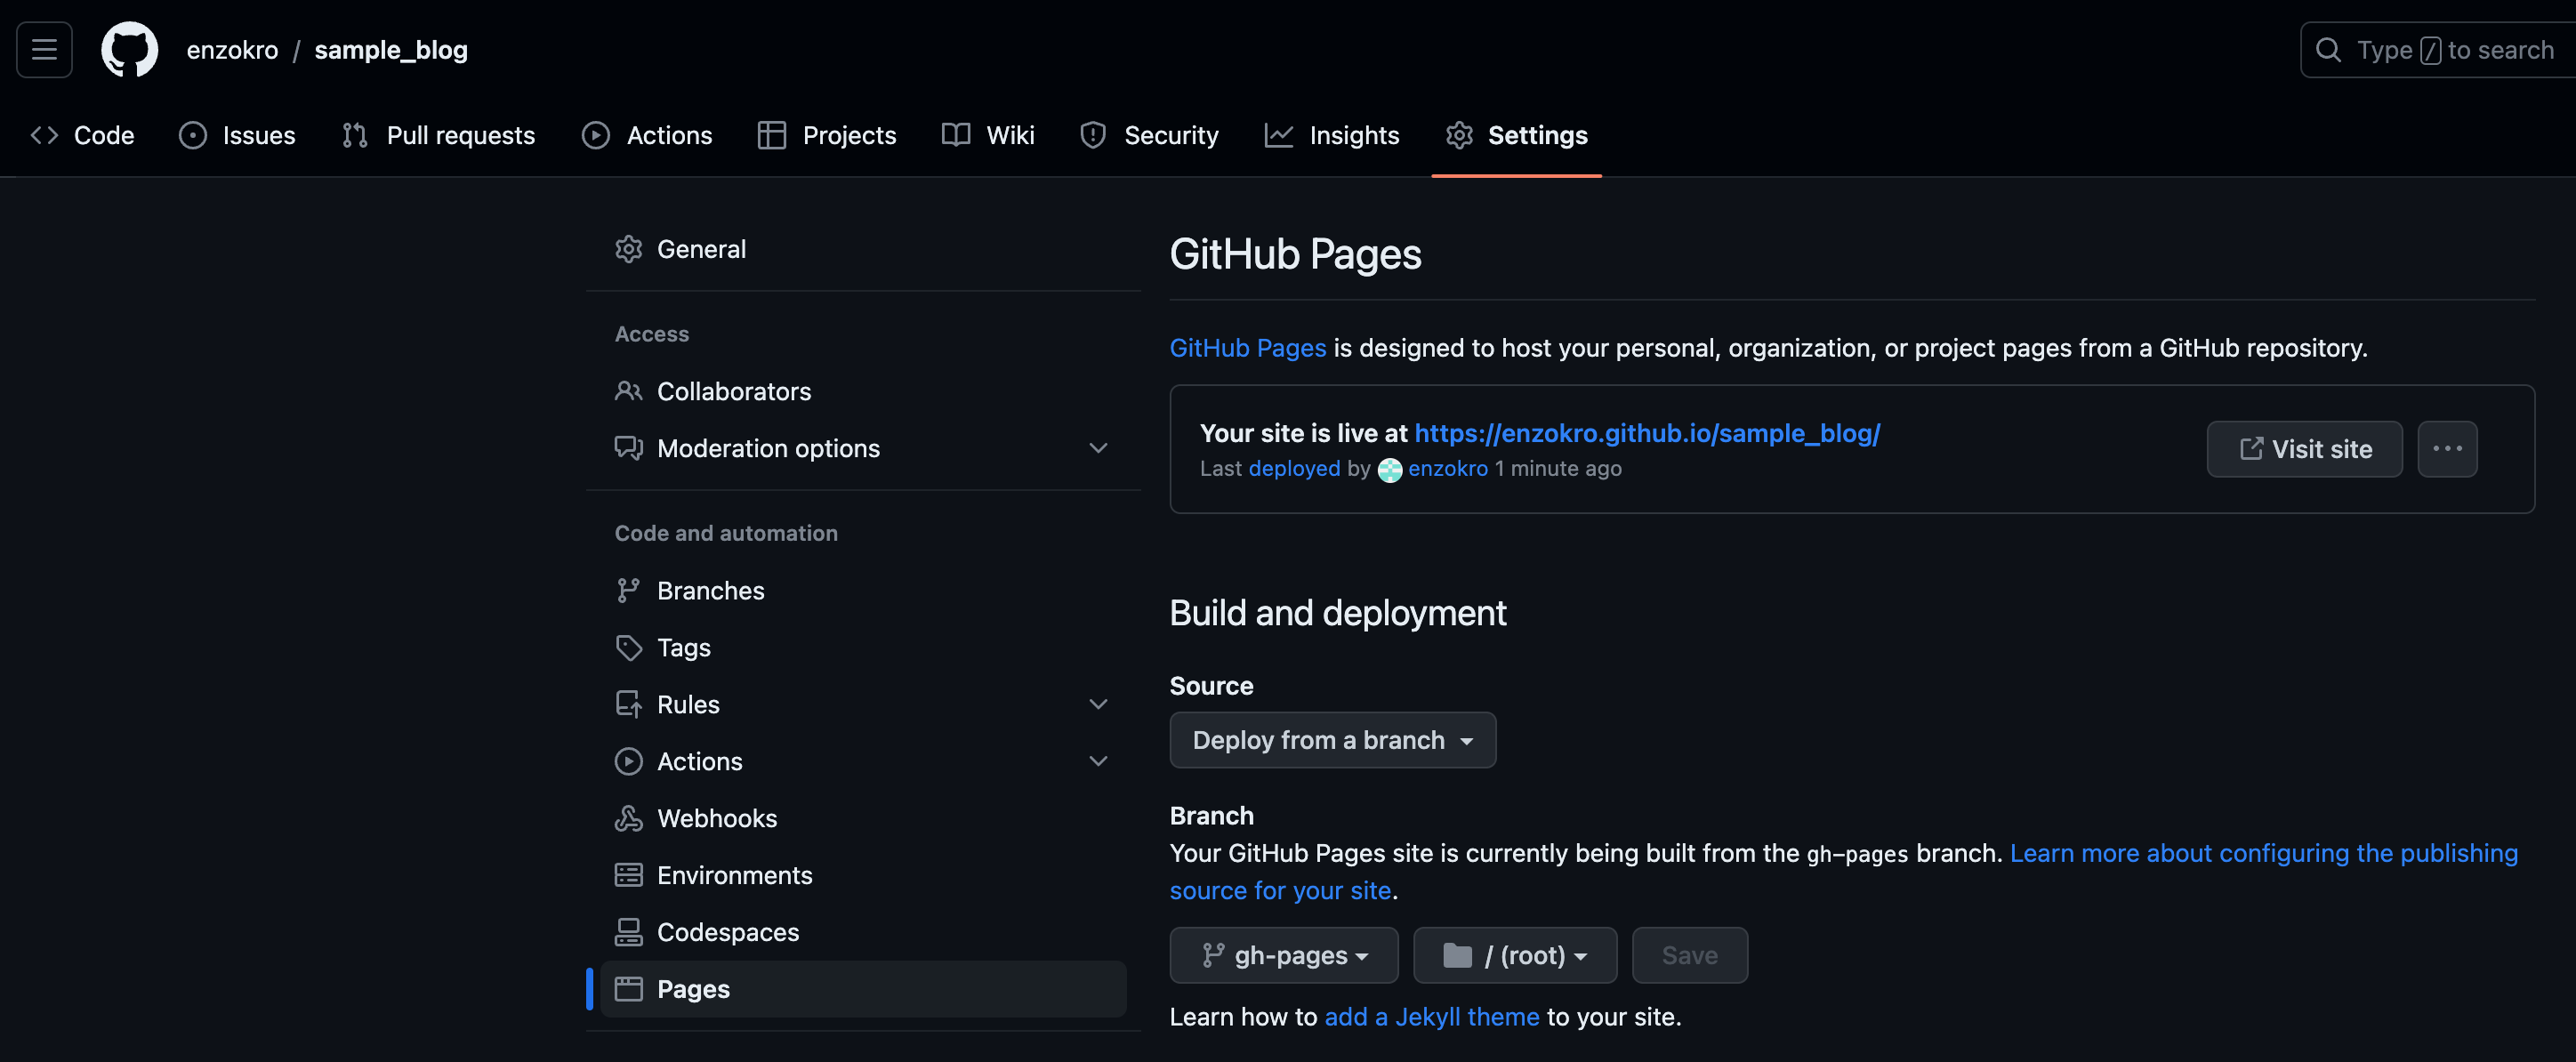

And that's all there is to it! We can now publish our first post. [Click here]() for a live link to this Notebook turned into a blog post. 

Now we've seen how `nbdev` lets us quickly create and setup a blog. Next we'll look at another one of its great capabilities: building a fully fledged python library.

## Creating python libraries with `nbdev`

`nbdev` has a set of helper commands that convert Notebooks into complete python libraries.  

These helper commands are called `directives` and usually go at the start of a code cell. They start with the special `#|` string which is similar to the shebang `#!` you may have seen in other scripts. These directive tell `nbdev` how to parse the code cell and what to do with it.

For example, the `default_exp` directive tells `nbdev` what to name an output python file. We use it below to name this specific python file as `lesson_2/simple_pipeline.py`: 

In [1]:
#| default_exp lesson_2.simple_pipeline

After we've named our soon-to-be python file, the `#| export` directive will parse and extract any python code cell we attach to it.

In [2]:
#| export  

# importing the pieces for the pipeline
from transformers import AutoConfig
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

/Users/cck/mambaforge/envs/llm_base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> A small annoyance: `import` statements have to be in their own code cell. We can't pair them with function calls like `print()`, for example.

Next, we refactor the code from the previous notebook (`01_first_run.ipynb`) into a simple class. 

In [6]:
#| export  

class SentimentPipeline:
    def __init__(self, model_name):
        """
        Sentiment Analysis pipeline.
        """
        self.model_name = model_name
        self.config = AutoConfig.from_pretrained(self.model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)


    def preprocess(self, text: str):
        """
        Sends `text` through the LLM's tokenizer.  
        The tokenizer turns words and characters into special inputs for the LLM.
        """
        tokenized_inputs = self.tokenizer(text, return_tensors='pt')
        return tokenized_inputs
    

    def forward(self, text: str):
        """
        First we preprocess the `text` into tokens.
        Then we send the `token_inputs` to the model.
        """
        token_inputs = self.preprocess(text)
        outputs = self.model(**token_inputs)
        return outputs
    

    def process_outputs(self, outs):
        """
        Here we mimic the post-processing that HuggingFace automatically does in its `pipeline`.  
        """
        # grab the raw scores from the model for Positive and Negative labels
        logits = outs.logits

        # find the strongest label score, aka the model's decision
        pred_idx = logits.argmax(1).item()

        # use the `config` object to find the actual class label
        pred_label = self.config.id2label[pred_idx]  

        # calculate the human-readable probability score for this class
        pred_score = logits.softmax(-1)[:, pred_idx].item()

        # return the predicted label and its score
        return {
            'label': pred_label,
            'score': pred_score, 
        }
    

    def __call__(self, text: str):
        """
        Overriding the call method to easily and intuitively call the pipeline.
        """
        model_outs = self.forward(text)
        preds = self.process_outputs(model_outs)
        return preds

    
    def __repr__(self):
        """
        Cleaner representation of the pipeline.
        """
        return f"SentimentAnalysis_{self.model_name}"

Let's now make sure that `SentimentPipeline` actually works, since live tests are one of the main benefits of Notebook coding! Note that since we don't put an `|# export` directive in the cell below, it won't be part of the exported python file either.


In [ ]:
# testing the pipeline

# loading the default model
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
classifier = SentimentPipeline(model_name) 

# make sure that the official HuggingFace example works as expected
results = classifier("We are very happy to show you the 🤗 Transformers library."); results
assert results['label'] == 'POSITIVE'

You can think of the cell above as a unit test for the `SentimentAnalysis` pipeline. `nbdev` runs this notebook when it compiles the library, and if the tests fail then the build fails. This is a great, built-in way of making sure that the library works as expected.

### Exporting the library  

We can now export the library using the `nbdev_build_lib` command. This will create a file inside of the top-level library folder `Fractal_LLM_Course`. Per the `default_exp` directive, the file will called  `lesson_2/simple_pipeline.py`.  



> Note: we can add nested library directories with the typical python dot (`.`) syntax. For example, if we'd instead used the directive `|# default_exp simple_pipeline`, then the file would live at the top-level library folder: `Fractal_LLM_Course/simple_pipeline.py`. Adding the `lesson_2.` created the `lesson_2/` folder for us.

The following set of commands will:  
- Export the Notebooks into a library.  
- Install the library as an editable install. 
- Import the newly installed library in a python shell.  

Make sure to run them from the top-level directory of the repo. 

```bash
# export Notebooks into a library
nbdev_export_lib  

# install the library as an editable install
pip install -e . 
```

Now open up a python shell to import and use the library. 

```python
# import the newly installed library 
from Fractal_LLM_Course.lesson_2.simple_pipeline import SentimentPipeline

# use our custom SentimentAnalysis pipeline!
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
classifier = SentimentPipeline(model_name) 
```

Congrats! We've now built and installed a full, working python library. This is just the start, `nbdev` has many other advanced tools you can [read about here](https://nbdev.fast.ai/tutorials/tutorial.html#advanced-functionality).

# Conclusion

This Notebook covered two key features of `nbdev`:  
- Creating a blog. 
- Building a python library.

Both of these features are great for research and development. We can quickly try new ideas and easily share them with others.